<div> <center><img src="https://storage.googleapis.com/open-ff-common/openFF_logo.png" width="100"/></div>
<h1><center>Proprietary notebook - Aug 2023</center></h1>

In [1]:
!git clone https://github.com/gwallison/intg_support.git &>/dev/null;
!pip install itables  &>/dev/null;
!pip install geopandas  &>/dev/null;

import urllib
urllib.request.urlretrieve('https://storage.googleapis.com/gwa-test/georef-united-states-of-america-county.geojson',
                            'counties.geojson')

('counties.geojson', <http.client.HTTPMessage at 0x798b5da1eec0>)

In [2]:
%run intg_support/proprietary_aug_2023.py

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import gca, mpl

%matplotlib inline
import seaborn as sns

# get full set of data
import intg_support.geo_tools as gt
work_dir = ''
# work_dir = './tmp'
get_fulldf(work_dir=work_dir) # this downloads most recent from the web.
df = get_df(os.path.join(work_dir,'full_df.parquet'))
df = df[df.in_std_filtered]

# NOW HAS FILTER to remove disclosures without chemicals!!
df = df[df.ingKeyPresent]

# uncomment following line to limit the dates
df = df[(df.date.dt.year>2013)&(df.date.dt.year<2023)]


In [4]:
# make a proprietary only data set
prop_df = df[df.bgCAS=='proprietary'].copy()


# identify as many proprietary proppants as we can

In [5]:
s = """30/70 Permian
aa-400 (aluminum oxide)
aluminum oxide
amorphous Silica
amorphous silica
amorphous silicia
ceramic microspheres
ceramic microspheres/glutaraldehyde
ceramic propant
ceramic proppant
ceramic proppant proprietary
copolymer resin fracturing proppant
corundum
crys4808-60-7talline sio2
crystalline cristobalite
crystalline silica
crystalline silica (quartz)
crystalline silica (quartz), proprietary
crystalline silica, quartz
crystalline silica: cristobalite
crystalline silica: quartz (sio2)
crystalline silica(quartz),proprietary
crystalline sio2
fumed silica
hydrophobic silica
hydrated magnesium silicate
magnesium silicate hydrate (talc)
meghemite
non- crystalline silica (impurity)
non-crystalline silica
proppant
proprietary quartz
proprietary silica
quartz
quartz (sio2)
sand
silica substrate
silica substitute with bonded coatings
silicate minerals - ts
zinc oxide"""
propp_lst = s.split('\n')

prop_df['is_proppant'] = prop_df.IngredientName.isin(propp_lst)
print(f'Total number of identified proprietary proppant records: {prop_df.is_proppant.sum()}')
prop_df[prop_df.is_proppant].IngredientName.value_counts()

Total number of identified proprietary proppant records: 1684


silica substrate                            532
silicate minerals - ts                      474
ceramic proppant                            220
hydrated magnesium silicate                  81
amorphous silica                             59
proprietary quartz                           58
fumed silica                                 55
crystalline sio2                             40
sand                                         31
corundum                                     28
crystalline silica (quartz)                  18
aa-400 (aluminum oxide)                      12
crystalline silica: quartz (sio2)            10
crystalline cristobalite                      8
proppant                                      7
ceramic microspheres                          7
copolymer resin fracturing proppant           6
silica substitute with bonded coatings        6
aluminum oxide                                5
non- crystalline silica (impurity)            3
quartz                                        3
hydrophobic silica                            3
magnesium silicate hydrate (talc)             3
zinc oxide                                    2
crystalline silica, quartz                    2
crystalline silica (quartz), proprietary      2
crystalline silica(quartz),proprietary        1
ceramic microspheres/glutaraldehyde           1
ceramic proppant proprietary                  1
crys4808-60-7talline sio2                     1
quartz (sio2)                                 1
ceramic propant                               1
meghemite                                     1
crystalline silica                            1
amorphous silicia                             1
Name: IngredientName, dtype: int64

In [6]:
# remove one obvious error point
import numpy as np
prop_df.calcMass = np.where(prop_df.calcMass>100000000,np.NaN,prop_df.calcMass)

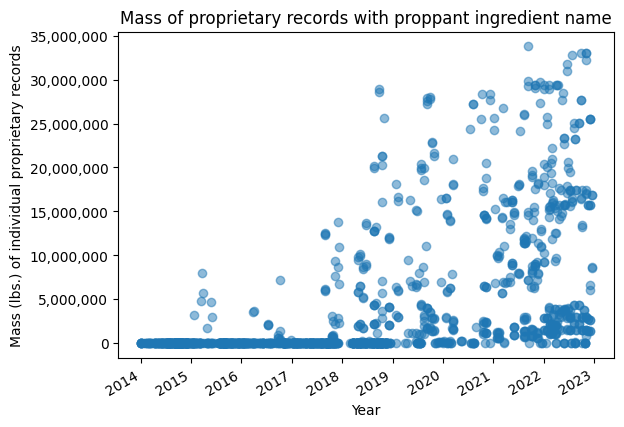

In [7]:
from pylab import gca, mpl
ax = prop_df[prop_df.is_proppant].plot('date','calcMass',style='o',alpha=.5,legend=False)
ax.set_title('Mass of proprietary records with proppant ingredient name')
ax.set_xlabel('Year')
ax.set_ylabel('Mass (lbs.) of individual proprietary records')
# prop_df[~prop_df.is_proppant].plot('date','calcMass', style='o',alpha=.2, ax=ax, legend=False)
ax = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

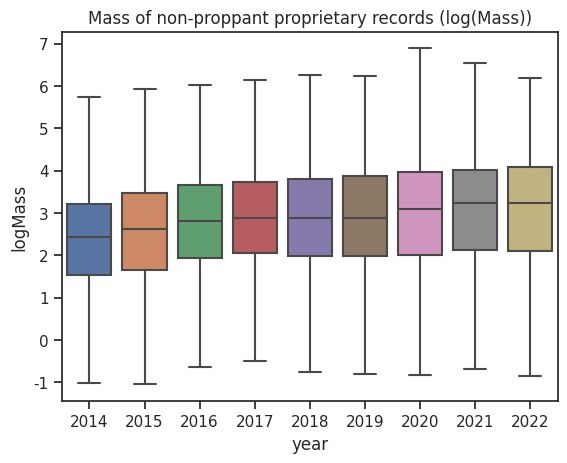

In [8]:
import seaborn as sns
import numpy as np
sns.set_theme(style="ticks")
prop_df['logMass'] = np.where(prop_df.calcMass>0.00001,np.log10(prop_df.calcMass),np.NaN)
prop_df['year'] = prop_df.date.dt.year
ax = sns.boxplot(data=prop_df[~prop_df.is_proppant], x='year',y='logMass',showfliers=False)
ax.set_title('Mass of non-proppant proprietary records (log(Mass))')
ax = gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [9]:
prop_df[~prop_df.is_proppant].groupby('year')['calcMass'].agg(['median','mean','sum','count'])

median          mean           sum   count
year                                                 
2014   275.453000   4879.929733  7.277976e+08  149141
2015   417.396669   5809.250756  4.741510e+08   81620
2016   636.135534   8444.178281  3.599415e+08   42626
2017   759.543448   7792.327195  4.501627e+08   57770
2018   751.032295  11174.954694  6.987923e+08   62532
2019   780.799410   9545.649249  5.015570e+08   52543
2020  1263.881000  13923.323653  3.682023e+08   26445
2021  1711.424000  14877.300504  5.309857e+08   35691
2022  1689.392137  16499.328506  7.192882e+08   43595

# basic proprietary stats (added 8/28)

In [10]:
print(f'Total calculated mass of proprietary records: {round_sig(prop_df.calcMass.sum(),3)} lbs.')
prop_df['added_year'] = prop_df.date_added.dt.year
print(f'Calculated mass of proprietary records added in 2023: {round_sig(prop_df[prop_df.added_year==2023].calcMass.sum(),3)} lbs.')

prop_df['year'] = prop_df.date.dt.year
# with pd.option_context("display.float_format", "{:,.0f}".format):
gb = prop_df.groupby('year',as_index=False)['calcMass'].sum()
gb['rounded'] = gb.calcMass.map(lambda x: round_sig(x,3))
gb

Total calculated mass of proprietary records: 10,400,000,000 lbs.
Calculated mass of proprietary records added in 2023: 1,210,000,000 lbs.


year      calcMass        rounded
0  2014  7.279581e+08    728,000,000
1  2015  5.052286e+08    505,000,000
2  2016  3.853328e+08    385,000,000
3  2017  5.801458e+08    580,000,000
4  2018  1.202173e+09  1,200,000,000
5  2019  1.129773e+09  1,130,000,000
6  2020  9.670443e+08    967,000,000
7  2021  1.929830e+09  1,930,000,000
8  2022  2.962242e+09  2,960,000,000

In [11]:
total_num_disc = df.UploadKey.unique().size
num_disc_with_prop = prop_df.UploadKey.unique().size
print(f'Total num of disclosures in set:      {total_num_disc:,}')
print(f'Total with at least one propriertary: {num_disc_with_prop:,}')
print(f'Overall Percent with proprietary:     {num_disc_with_prop/total_num_disc:.2%}')

Total num of disclosures in set:      131,826
Total with at least one propriertary: 108,896
Overall Percent with proprietary:     82.61%


# show all the Purpose fields
You could also look at the [Browser's version](https://storage.googleapis.com/open-ff-browser/proprietary/analysis_proprietary.html#raw) of this.  Extra long purposes (using indicating multiple products) are truncated and combined.  They are not very useful...

In [12]:
prop_df.groupby('Purpose',as_index=False).size()

Purpose  size
0                   "Other Ingredient(s)"    10
1                     (Other Ingredients)    22
2                     *3rd Party Additive   114
3     *3rd Party Additive Scale Inhibitor     8
4              *3rd Party Scale Inhibitor    17
...                                   ...   ...
1603                              solvent     2
1604                           surfactant     1
1605                       synthetic acid     1
1606                viscosifier for water     6
1607            water recovery surfactant     8

[1608 rows x 2 columns]

# make graphs of operators and suppliers

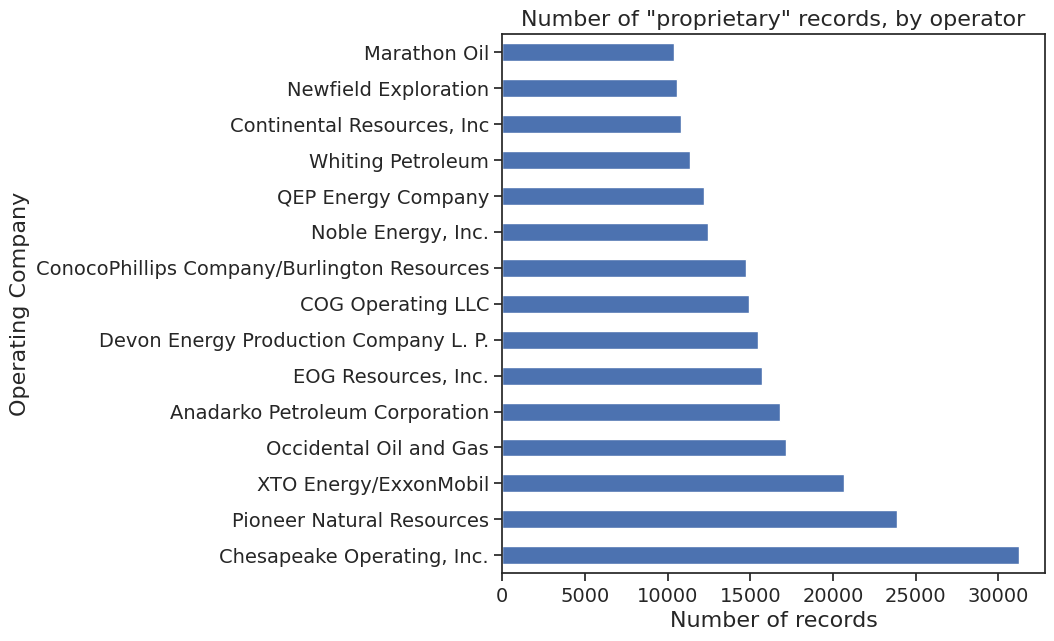

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# cas = prop_df.bgCAS.iloc[0]
# use the most common name given in FF for the label
gb1 = prop_df.groupby('bgOperatorName')['OperatorName'].agg(lambda x: x.value_counts().index[0])
gb1 = gb1.reset_index()
gb1.columns = ['bgOperatorName','op_common']
mg = pd.merge(prop_df,gb1,on='bgOperatorName',how='left')
newmg = mg.groupby('op_common')['UploadKey'].count().sort_values(ascending=False)
ax = newmg[:15].plot.barh(figsize=(7,7))
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of records',fontsize=16);
plt.ylabel('Operating Company',fontsize=16);
plt.title(f'Number of "proprietary" records, by operator',fontsize=16);

In [14]:
gb_full = df.groupby(['bgOperatorName','UploadKey'],as_index=False).size()
gb_full = gb_full.groupby('bgOperatorName')['UploadKey'].count().reset_index()
gb_full.columns = ['bgOperatorName','disclosure_cnt_all']

gb_prop = prop_df.groupby(['bgOperatorName','UploadKey'],as_index=False).size()
gb_prop = gb_prop.groupby('bgOperatorName')['UploadKey'].count().reset_index()
gb_prop.columns = ['bgOperatorName','disclosure_cnt_prop']



In [15]:
mg = pd.merge(gb_full,gb_prop,on='bgOperatorName',how='left')
mg = pd.merge(mg,gb1,on='bgOperatorName',how='left')
mg = pd.merge(mg,newmg.reset_index(),on='op_common',how='left')
mg = mg.rename({'UploadKey':'num_prop_records'},axis=1)
mg = mg[mg.disclosure_cnt_prop>0]
mg.disclosure_cnt_prop.fillna(0,inplace=True)
mg['prop_perc'] = mg.disclosure_cnt_prop/mg.disclosure_cnt_all * 100
mg.sort_values('disclosure_cnt_all',ascending=False)

bgOperatorName  disclosure_cnt_all  disclosure_cnt_prop  \
442                            eog                5960               5438.0   
1385                           xto                4719               4071.0   
43              anadarko petroleum                3951               3441.0   
260                     chesapeake                3660               3346.0   
934                        pioneer                3403               3289.0   
...                            ...                 ...                  ...   
268            churchill operating                   1                  1.0   
715                      lightning                   1                  1.0   
1138         southlake exploration                   1                  1.0   
1137  southern oklahoma production                   1                  1.0   
922                      petroplex                   1                  1.0   

                           op_common  num_prop_records   prop_perc  
442              EOG Resources, Inc.           15708.0   91.241611  
1385           XTO Energy/ExxonMobil           20686.0   86.268277  
43    Anadarko Petroleum Corporation           16784.0   87.091875  
260       Chesapeake Operating, Inc.           31239.0   91.420765  
934        Pioneer Natural Resources           23853.0   96.650015  
...                              ...               ...         ...  
268         Churchill Operating, LLC               5.0  100.000000  
715            Lightning Oil Company               9.0  100.000000  
1138      Southlake Exploration Inc.               2.0  100.000000  
1137    Southern Oklahoma Production               3.0  100.000000  
922            Petroplex Energy Inc.               7.0  100.000000  

[1192 rows x 6 columns]

# Suppliers

Here we need to remove records that are systems approach

In [16]:
c = df.CASNumber.str.lower().str.contains('listed below')
c1 = df.IngredientName.str.lower().str.contains('listed below')
print(f'Number of disclosures that are systems approach removed from consideration : {df[c1|c].UploadKey.unique().size}')
upk = df[c1|c].UploadKey.unique().tolist()
prop_df_sup = prop_df[~prop_df.UploadKey.isin(upk)]
print(f'Number of disclosures in the supplier analysis: {prop_df_sup.UploadKey.unique().size}')

Number of disclosures that are systems approach removed from consideration : 42736
Number of disclosures in the supplier analysis: 74447


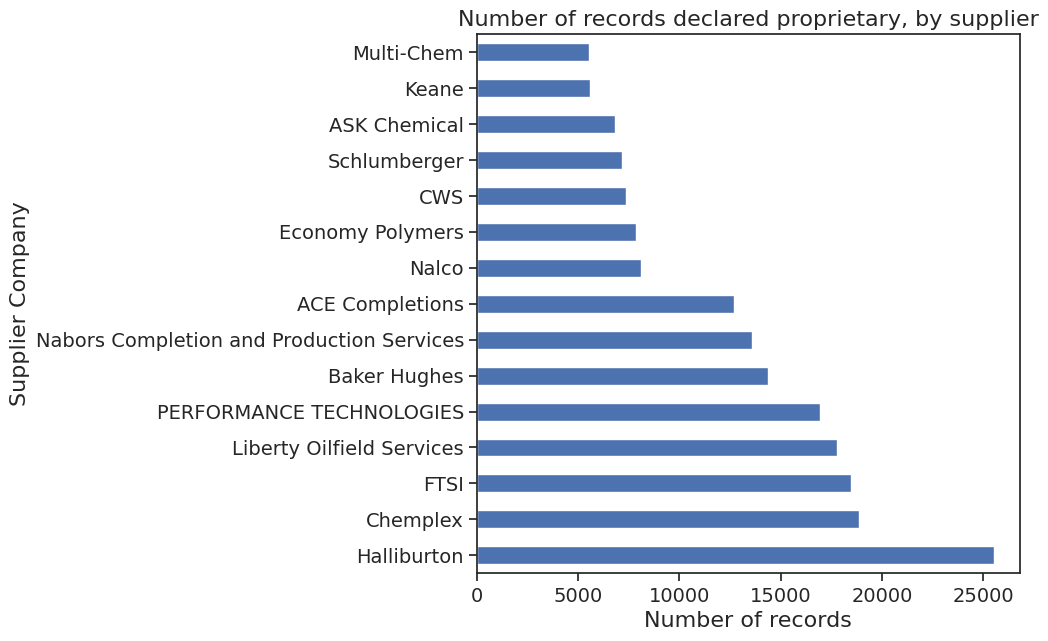

In [17]:
# records to exclude
not_comp = ['MISSING','Listed Above']

gb1 = prop_df_sup.groupby('bgSupplier')['Supplier'].agg(lambda x: x.value_counts().index[0])
gb1 = gb1.reset_index()
gb1.columns = ['bgSupplier','sup_common']
mg = pd.merge(prop_df_sup,gb1,on='bgSupplier',how='left')

mg = mg[~mg.sup_common.isin(not_comp)]

ax = mg.groupby('sup_common')['UploadKey'].count()\
         .sort_values(ascending=False)[:15].plot.barh(figsize=(7,7))
ax.tick_params(axis="y", labelsize=14)
ax.tick_params(axis="x", labelsize=14)
plt.xlabel('Number of records',fontsize=16);
plt.ylabel('Supplier Company',fontsize=16);
plt.title(f'Number of records declared proprietary, by supplier',fontsize=16);

In [18]:
gb_full = df.groupby(['bgSupplier'],as_index=False).size()
gb_full.columns = ['bgSupplier','record_cnt_all']

gb_prop = prop_df_sup.groupby(['bgSupplier'],as_index=False).size()
gb_prop.columns = ['bgSupplier','record_cnt_prop']

# gb_precs = prop_df.groupby

In [19]:
mg = pd.merge(gb_full,gb_prop,on='bgSupplier',how='left')
mg = pd.merge(mg,gb1,on='bgSupplier',how='left')
mg.record_cnt_prop.fillna(0,inplace=True)
mg['prop_perc'] = mg.record_cnt_prop/mg.record_cnt_all * 100
mg.sort_values('record_cnt_all',ascending=False)

bgSupplier  record_cnt_all  record_cnt_prop    sup_common  \
815           missing         1590762         131193.0       MISSING   
588       halliburton          376651          25531.0   Halliburton   
1151     schlumberger          219086           7144.0  Schlumberger   
263          chemplex          190956          18878.0      Chemplex   
888     not a company          138803          14818.0  Listed Above   
...               ...             ...              ...           ...   
972   petro harvester               1              0.0           NaN   
961               pep               1              0.0           NaN   
955             pearl               1              0.0           NaN   
954    peak operating               1              0.0           NaN   
0          24-7 sands               1              0.0           NaN   

      prop_perc  
815    8.247180  
588    6.778424  
1151   3.260820  
263    9.886047  
888   10.675562  
...         ...  
972    0.000000  
961    0.000000  
955    0.000000  
954    0.000000  
0      0.000000  

[1466 rows x 5 columns]

# MAPS

In [20]:
import geopandas as gpd
import folium
import numpy as np

import branca.colormap as cm
linear = cm.LinearColormap(['green','yellow','red'], vmin=3., vmax=10.)
linear

def fix_county_names(df):
    trans = {'mckenzie':'mc kenzie',
             'dewitt':'de witt',
             'mcclain':'mc clain',
             'mcintosh':'mc intosh',
             'mckean':'mc kean',
             'mcmullen':'mc mullen'}
    for wrong in trans.keys():
        df.CountyName = np.where(df.CountyName==wrong,trans[wrong],df.CountyName)
    return df

def create_county_choropleth(data,
                             start_loc=[40, -96],start_zoom = 6,
                             custom_scale = [], plotlog = True,
                             legend_name = 'Test legend',
                             show_only_data_states=True,
                             fill_color = 'YlOrRd',
                             #popup_enabled=True, tooltip_enabled=False,
                             fields = ['CountyName','orig_value'],
                             aliases = ['County: ','data: ']):
    fn = r"counties.geojson"
    if len(data)<1:
        print('No mappable data')
        return
    geojson = gpd.read_file(fn)
    data['orig_value'] = data.value

    geojson['StateName'] = geojson.ste_name.str.lower()
    geojson['CountyName'] = geojson.coty_name.str.lower()
    geojson = fix_county_names(geojson)
    working = geojson[['StateName','CountyName','coty_code','geometry']]
    #geojson = geojson.to_crs(5070)
    working = pd.merge(working,data,on=['StateName','CountyName'],how='left')
    #print(geojson.info())
    if start_loc==[]:
        start_loc = [geojson.geometry.centroid.x.mean(),geojson.geometry.centroid.y.mean()]
    f = folium.Figure(width=600, height=400)
    m = folium.Map(location= start_loc, tiles="openstreetmap",
                   zoom_start=start_zoom).add_to(f)
    if plotlog:
        working.value = np.log10(working.value+1)
        legend_name = legend_name + ' (log transformed)'
    working.orig_value.fillna('no data',inplace=True)

    if custom_scale==[]:
        custom_scale = (working['value'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()
    if show_only_data_states:
        gb = data.groupby(['StateName','CountyName'],as_index=False)['value'].first()
        datalst = []
        for i,row in gb.iterrows():
            datalst.append((row.StateName,row.CountyName))
        wlst = []
        working['tup'] = list(zip(working.StateName.tolist(),working.CountyName.tolist()))
        geojson['tup'] = list(zip(geojson.StateName.tolist(),geojson.CountyName.tolist()))

#         working = working[working.StateName.isin(data.StateName.unique().tolist())]
#         geojson = geojson[geojson.StateName.isin(data.StateName.unique().tolist())]
#         c1 = working.CountyName.isin(data.CountyName.unique().tolist())
#         c2 = working.StateName.isin(data.StateName.unique().tolist())
#         c3 = geojson.CountyName.isin(data.CountyName.unique().tolist())
#         c4 = geojson.StateName.isin(data.StateName.unique().tolist())
        working = working[working.tup.isin(datalst)]
        geojson = geojson[geojson.tup.isin(datalst)]
    working.StateName = working.StateName.str.title()
    working.CountyName = working.CountyName.str.title()
    #print(f'States in geojson: {working.StateName.unique().tolist()}')

    linear = cm.LinearColormap(['green','yellow','red'], vmin=3., vmax=10.)
    linear

    folium.Choropleth(
                geo_data=geojson,
                data=working,
                columns=['coty_code', 'value'],  #Here we tell folium to get the fips and plot values for each state
                key_on='feature.properties.coty_code',
                threshold_scale=custom_scale, #use the custom scale we created for legend
                #fill_color='YlOrRd',
                fill_color=fill_color,
                nan_fill_color="gainsboro", #Use white color if there is no data available for the area
                fill_opacity=0.7,
                line_opacity=0.4,
                line_weight=0.4,
                legend_name= legend_name, #title of the legend
                highlight=True,
                line_color='black').add_to(m)

    folium.features.GeoJson(
                data=working,
                name='',
                smooth_factor=2,
                style_function=lambda x: {'color':'black','fillColor':'transparent','weight':0.5},
                popup=folium.features.GeoJsonPopup(
                    fields=fields,
                    aliases=aliases,
                    localize=True,
                    sticky=False,
                    labels=True,
                    style="""
                        background-color: #F0EFEF;
                        border: 2px solid black;
                        border-radius: 3px;
                        box-shadow: 3px;
                    """,
                    max_width=800,),
                        highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                    ).add_to(m)



# fit_bounds needs work: https://stackoverflow.com/questions/58162200/pre-determine-optimal-level-of-zoom-in-folium
#     sw = data[['bgLatitude', 'bgLongitude']].min().values.tolist()
#     ne = data[['bgLatitude', 'bgLongitude']].max().values.tolist()

#     m.fit_bounds([sw, ne])
    display(f)


def CountyMap(df):
    state_list = df.bgStateName.unique().tolist()
    #start_loc = get_geog_center(state_list)
    #print(statename,start_loc)
    cond = (df.loc_within_state=='YES')&(df.loc_within_county=='YES')
    if cond.sum()==0:  # no valid fracks for this state
        display(md('## No mappable fracks for this operator!'))
        # display(md(f'Any data in this state set may be labeled incorrectly as {statename}'))
        return
    gb = df[cond].groupby(['bgStateName','bgCountyName',
                                                   'UploadKey'],as_index=False)['bgCAS'].count()
    gb = gb.groupby(['bgStateName','bgCountyName'],as_index=False)['UploadKey'].count().rename({'bgStateName':'StateName',
                                                                                                'bgCountyName':'CountyName',
                                                                                                'UploadKey':'value'},
                                                                                                axis=1)
    zoom = 3.6
    create_county_choropleth(gb,plotlog=True,#plotlog=True,
                             custom_scale= [0,1,2,3,4],
                             #start_loc=start_loc, # center of state's data
                             legend_name='Number of FracFocus disclosures',
                             start_zoom=zoom,fields=['StateName','CountyName','orig_value'],
                             aliases=['State: ','County: ','Number Fracking disclosures: '])

## Map by number of disclosures
Does this color scheme support our points?

In [21]:
CountyMap(prop_df)

# make map with proprietary fraction

83.01054275673565

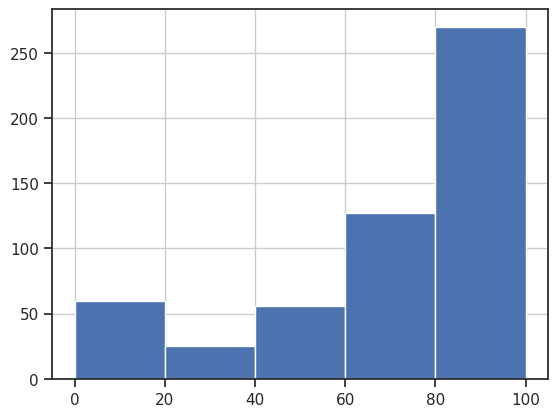

In [22]:
# first make data frame with number of fracks by county
gb_all = df.groupby(['bgStateName','bgCountyName','APINumber'],as_index=False).size()
gb_all = gb_all.groupby(['bgStateName','bgCountyName'],as_index=False)['APINumber'].count()
# gb_all

# now make data frame with number of fracks with at least one prop. chem by county
gb_prop = prop_df.groupby(['bgStateName','bgCountyName','APINumber'],as_index=False).size()
gb_prop = gb_prop.groupby(['bgStateName','bgCountyName'],as_index=False)['APINumber'].count()
gb_prop.columns = ['bgStateName','bgCountyName','APINumber_prop']
gb_prop

mg = pd.merge(gb_all,gb_prop,on=['bgStateName','bgCountyName'],how='left')
mg.APINumber_prop.fillna(0,inplace=True)
mg['perc_prop'] = mg.APINumber_prop/mg.APINumber *100
mg[mg.APINumber>0].perc_prop.hist(bins=5)

mg['prop_dev'] = mg.perc_prop - 82

mg.APINumber_prop.sum()/mg.APINumber.sum() *100

## %disclosures_with_proprietary: 4 simple categories
I like this one - gary

In [23]:
def CountyPropMap(df):
    state_list = df.bgStateName.unique().tolist()
    zoom = 3.6
    df['value'] = df.perc_prop
    # df['value'] = df.prop_dev
    df['StateName'] = df.bgStateName
    df['CountyName'] = df.bgCountyName
    create_county_choropleth(df,plotlog=False,
                             custom_scale=[0,25,50,75,100],
                             fill_color='RdBu_r',
                             #start_loc=start_loc, # center of state's data
                             legend_name='Percent of disclosures with at least one proprietary record',
                             start_zoom=zoom,fields=['bgStateName','bgCountyName','orig_value','APINumber'],
                             aliases=['State: ','County: ','% disc with proprietary: ','total num of disclosures'])

CountyPropMap(mg[mg.APINumber>5].copy()) # county must have more than 5 FF wells

## %disclosures_with_proprietary:
## 5 categories based on distribution around median
I find this one confusing, at least to our main point - gary

In [24]:
# def CountyPropMap(df):
#     state_list = df.bgStateName.unique().tolist()
#     # cond = (df.loc_within_state=='YES')&(df.loc_within_county=='YES')
#     # if cond.sum()==0:  # no valid fracks for this state
#     #     display(md('## No mappable fracks for this operator!'))
#     #     return
#     zoom = 3.6
#     df['value'] = df.perc_prop
#     # df['value'] = df.prop_dev
#     df['StateName'] = df.bgStateName
#     df['CountyName'] = df.bgCountyName
#     create_county_choropleth(df,plotlog=False,#custom_scale= [0,10,20,30,40,50,60,70,80,90,100],
#                              custom_scale=[0,76,81,88,95,100],
#                              #custom_scale=[0,25,50,75,100],
#                              #start_loc=start_loc, # center of state's data
#                              legend_name='Percent of disclosures with at least one proprietary record',
#                              start_zoom=zoom,fields=['bgStateName','bgCountyName','orig_value','APINumber'],
#                              aliases=['State: ','County: ','% disc with proprietary: ','total num of disclosures'])

# CountyPropMap(mg[mg.APINumber>5].copy()) # county must have more than 5 FF wells
# # CountyPropMap(mg.copy())

# Compare to Trickey 2020
state-wide proprietary rates

In [25]:
gb_all = df.groupby(['bgStateName','UploadKey'],as_index=False).size()
gb_all = gb_all.groupby('bgStateName',as_index=False)['UploadKey'].count()
gb_all.columns = ['bgStateName','num_all_disc']

gb_prop = df[df.bgCAS=='proprietary'].groupby(['bgStateName','UploadKey'],as_index=False).size()
gb_prop = gb_prop.groupby('bgStateName',as_index=False)['UploadKey'].count()
gb_prop.columns = ['bgStateName','num_prop_disc']

mg = pd.merge(gb_all,gb_prop,on='bgStateName',how='left')
mg.num_prop_disc.fillna(0,inplace=True)

mg['state_prop_percent'] = mg.num_prop_disc/mg.num_all_disc *100
mg.sort_values('num_all_disc',ascending=False)

bgStateName  num_all_disc  num_prop_disc  state_prop_percent
23           texas         63508        54734.0           86.184418
21        oklahoma         13188         9812.0           74.400971
4         colorado         11447        10143.0           88.608369
19    north dakota         10302         9193.0           89.235100
16      new mexico          8257         7360.0           89.136490
22    pennsylvania          6415         4674.0           72.860483
27         wyoming          3514         2749.0           78.229937
24            utah          2736         2514.0           91.885965
20            ohio          2625         2155.0           82.095238
10       louisiana          2600         2188.0           84.153846
26   west virginia          2450         1828.0           74.612245
3       california          2253            8.0            0.355082
2         arkansas           827          483.0           58.403869
25        virginia           469          330.0           70.362473
8           kansas           451          210.0           46.563193
13         montana           352          241.0           68.465909
1           alaska           176           87.0           49.431818
12     mississippi           134           83.0           61.940299
0          alabama            56           52.0           92.857143
9         kentucky            34           33.0           97.058824
11        michigan            11            8.0           72.727273
14        nebraska             8            4.0           50.000000
15          nevada             4            4.0          100.000000
17        new york             3            2.0           66.666667
7          indiana             2            0.0            0.000000
6         illinois             2            0.0            0.000000
18  north carolina             1            1.0          100.000000
5            idaho             1            0.0            0.000000

# ambiguousID

In [26]:
amb_df = df[df.bgCAS=='ambiguousID'].copy()
amb_df['has_mass'] = amb_df.calcMass>0
amb_df.has_mass.value_counts()

False    49564
True     30213
Name: has_mass, dtype: int64

## what are the ambiguousID `IngredientName`s


In [27]:
amb_df[amb_df.has_mass].IngredientName.value_counts()

no hazardous ingredients                           4064
water (including mix water supplied by client)*    3036
walnut hulls                                        856
enzyme                                              636
surfactants                                         629
                                                   ... 
antifoam                                              1
alkoxylated amine                                     1
alkylene oxide block polymer                          1
nfidb:15% fe acid                                     1
alkyl phoshonate                                      1
Name: IngredientName, Length: 690, dtype: int64

## what are the ambiguousID `IngredientName`s  (Just the big ones)
Mostly water-type things.  A handful of proppants

In [28]:
amb_df[amb_df.calcMass>100000].IngredientName.value_counts()

water (including mix water supplied by client)*         3031
silica substrate                                         336
carrier / base fluid - water                             248
no hazardous ingredients                                 172
water (including mix water supplied by client)           146
                                                        ... 
7647-01-0                                                  1
petroleum distillates, hydrotreated light                  1
no hazardous substances above cut-off values               1
contains no hazardous materials above cut-off values       1
3rd party clay control                                     1
Name: IngredientName, Length: 143, dtype: int64

# AmbiguousID Proppants: Number and mass

In [29]:
proppants = ['silica substrate',
 'remainder is made up of various other oxides and trace elements, of which cao, mgo, and fe2o3 are the largest percentages',
 'cyrstalline silica','mix of various oxides (cao, mgo, and fe2o4','resin coated fracturing proppant',
 '40/70 ppc','mix of various oxides (cao, mgo, and fe2o3',
 'mix of various oxides (cao, mgo, and fe203','mix of various oxides (cao, mgo, and fe204',
 'crystalline silica, quartz','100 mesh sand','ceramic',
 '20/40 pc','crystalline silica,quartz','aluminum oxide','nfidb:sand-200 mesh silica',
 'nfidb:200 mesh ssa-1','non-crystalline silica (impurity)',
 'silica in form of quartz','40/70 white','mulite']
c = amb_df.IngredientName.isin(proppants)

print(f'Number of ambiguousID proppants = {len(amb_df[c])}; calculated mass= {round(amb_df[c].calcMass.sum(),0):,} lbs.')

Number of ambiguousID proppants = 2545; calculated mass= 453,785,833.0 lbs.


## Likely water records in ambiguousID

In [30]:
c = amb_df.IngredientName.str.contains('water')

print(f'Number of ambiguousID **water** = {len(amb_df[c])}; calculated mass= {round(amb_df[c].calcMass.sum(),0):,} lbs.')

Number of ambiguousID **water** = 4428; calculated mass= 152,380,591,226.0 lbs.


# Proprietary plot (added back 8/28)

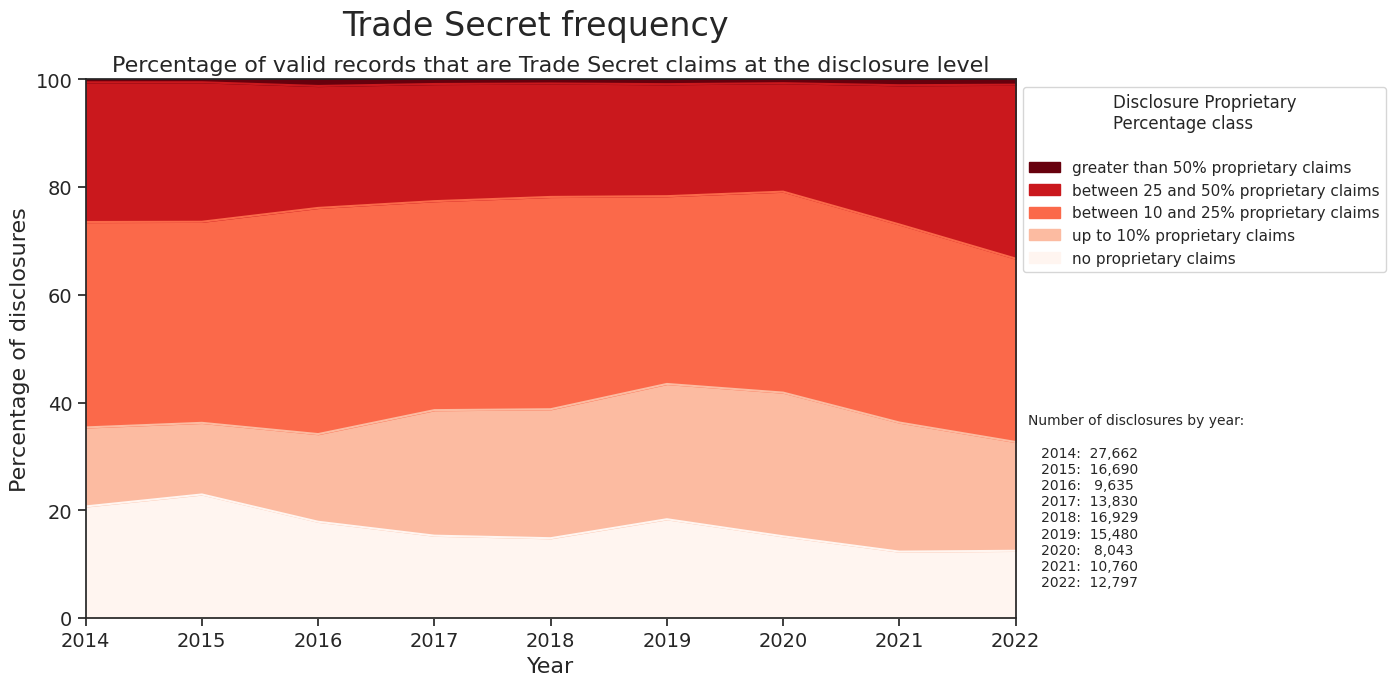

In [31]:

from matplotlib.offsetbox import AnchoredText
def proprietary_plot(df,plot_title='TEST',minyr=2014,maxyr=2022):
    df = df.copy()
    df['year'] = df.date.dt.year
    df = df[df.year<=maxyr]
    df = df[df.year>=minyr]
    prop = df.bgCAS=='proprietary'
    gb = df[prop].groupby('UploadKey',as_index=False)['bgCAS'].count().rename({'bgCAS':'numprop'},axis=1)
    gb1 = df[df.is_valid_cas].groupby('UploadKey',as_index=False)['bgCAS'].count().rename({'bgCAS':'numvalid'},axis=1)
    gb2 = df.groupby('UploadKey',as_index=False)['date'].first()
    mg = pd.merge(gb2,gb,on='UploadKey',how='left')
    mg = pd.merge(mg,gb1,on='UploadKey',how='left')
    mg.fillna(0,inplace=True) # there will be disclosures with 0 proprietary; need to fill
    mg['percProp'] = (mg.numprop / mg.numvalid) * 100

    mg['propCut'] = pd.cut(mg.percProp,right=False,bins=[0,0.0001,10,25,50,101],
                          labels=['no proprietary claims','up to 10% proprietary claims',
                                  'between 10 and 25% proprietary claims',
                                  'between 25 and 50% proprietary claims',
                                  'greater than 50% proprietary claims'])
    mg['year'] = mg.date.dt.year
    # tmp = mg.groupby(['year','propCut'],as_index=False).size()
    # print(tmp.pivot(index='year',columns='propCut',values='size'))

    out = mg.drop(['date','UploadKey'],axis=1)
    t = out[out.numvalid>0].groupby(['year','propCut'],as_index=False)['numvalid'].count()
    sums = t.groupby('year',as_index=False)['numvalid'].sum().rename({'numvalid':'tot'},axis=1)
    t = pd.merge(t,sums,on='year',how='left')
    t['PercentProp'] = t.numvalid/t.tot *100

    piv = t.pivot(index='year', columns='propCut', values='PercentProp')

    with pd.option_context("display.float_format", "{:,.1f} %".format):
        iShow(piv)

    ax = piv.plot.area(figsize=(12,7),ylim=(0,100),xlim=(minyr,maxyr),colormap='Reds')
    ax.set_title(f'Percentage of valid records that are Trade Secret claims at the disclosure level', fontsize=16)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Disclosure Proprietary\nPercentage class\n',
              loc='upper left',bbox_to_anchor=(1, 1))
    ax.set_ylabel('Percentage of disclosures', fontsize=16)
    ax.set_xlabel('Year', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.suptitle(f'{plot_title}',fontsize=24)

    gb = df.groupby(['year','UploadKey'],as_index=False)['bgCAS'].count()
    gb = gb.groupby('year',as_index=False)['UploadKey'].count()#.rename({'UploadKey':'number of disclosures'},axis=1)
    s = 'Number of disclosures by year:\n\n'
    for i,row in gb.iterrows():
        s+= f'   {row.year}: {row.UploadKey:7,} \n'
    at2 = AnchoredText(s,
                       loc='lower left', prop=dict(size=10), frameon=False,
                       bbox_to_anchor=(1., 0.),
                       bbox_transform=ax.transAxes
                       )
    at2.patch.set_boxstyle("square,pad=0.")
    ax.add_artist(at2)


# test = 'pennsylvania'
# variable = 'bgStateName'
testtitle = 'Trade Secret frequency'
proprietary_plot(df,testtitle,minyr=2014,maxyr=2022)
